In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# **Data Augumentation**

In [4]:
# Dataset path
dataset_path = '/kaggle/input/lung-disease/Chest Diseases Dataset (2)'

# Correcting class labels for binary classification
binary_classes = {'4. Atelectasis': 1, '9. Normal': 0}

# image paths and labels
X, Y = [], []
for folder, label in binary_classes.items():
    disease_path = os.path.join(dataset_path, folder, 'CXR')
    if not os.path.isdir(disease_path):  
        disease_path = os.path.join(dataset_path, folder)  # Use direc  t folder if 'CXR' is missing
    
    if os.path.isdir(disease_path):
        for img_name in os.listdir(disease_path):
            img_path = os.path.join(disease_path, img_name)
            X.append(img_path)
            Y.append(label)

# Converting lists to NumPy arrays
X, Y = np.array(X), np.array(Y)
print(f"Total images: {len(X)}")

# Convert integer labels to string labels
Y = np.array([['Normal', 'Atelectasis'][y] for y in Y])

# Convert to DataFrame
df = pd.DataFrame({'Image': X, 'Label': Y})

# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'], random_state=42)

# Image Data Generator with EfficientNet preprocessing
image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# create data generators with explicit class order
def create_data_generator(df, shuffle=True):
    generator = image_generator.flow_from_dataframe(
        df,
        x_col='Image',
        y_col='Label',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary',
        classes=['Normal', 'Atelectasis'],  # Enforce correct class order
        shuffle=shuffle
    )
    return generator

# generators with correct shuffle settings
train_generator = create_data_generator(train_df, shuffle=True)
val_generator = create_data_generator(val_df, shuffle=False)
test_generator = create_data_generator(test_df, shuffle=False)



Total images: 3912
Found 3129 validated image filenames belonging to 2 classes.
Found 391 validated image filenames belonging to 2 classes.
Found 392 validated image filenames belonging to 2 classes.


In [5]:
# class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weight_dict = dict(enumerate(class_weights))



**Data visualisation**

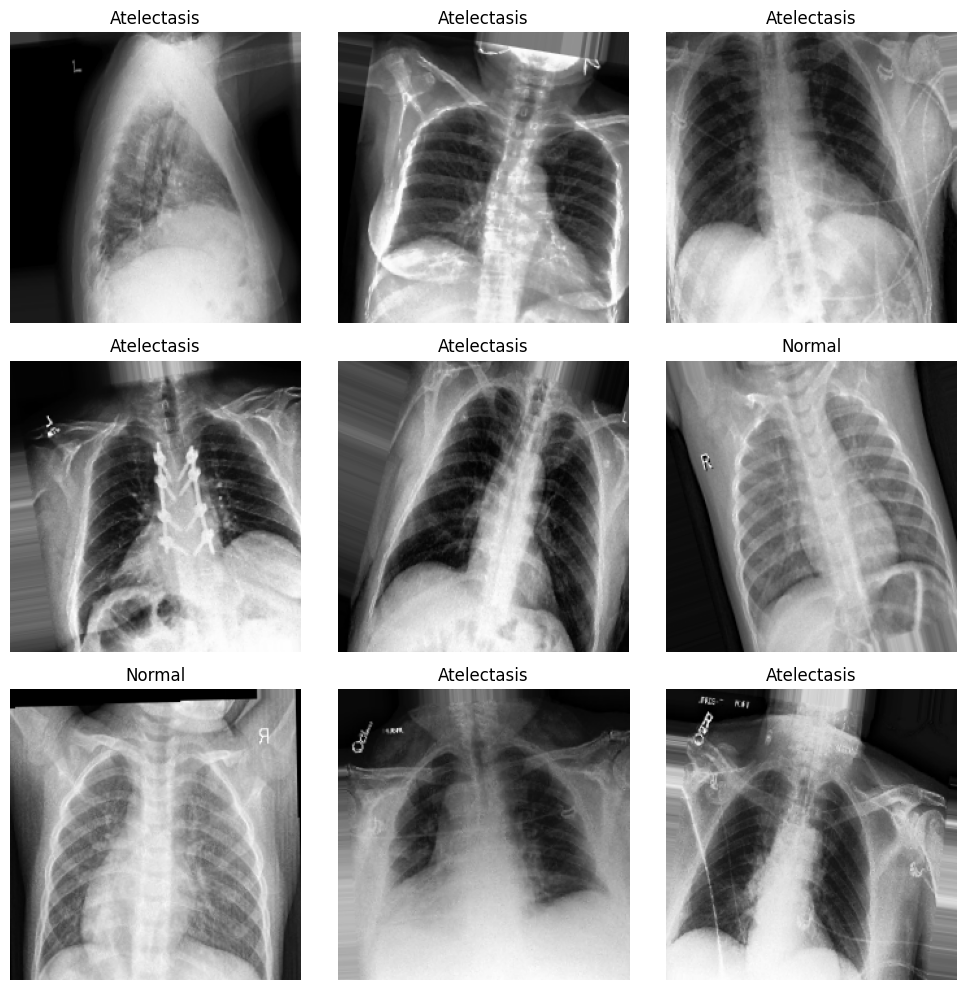

In [6]:
images, labels = next(train_generator)


num_images = min(9, len(images))


plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title("Atelectasis" if labels[i] == 1 else "Normal")
    plt.axis("off")

plt.tight_layout()
plt.show()

# **Model Architecture**

Using transfer **Learning with EfficientNetB0**

In [7]:
# model with optional fine-tuning

def build_model(fine_tune=False):
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    if fine_tune:
        base_model.trainable = True
        # Unfreeze top layers
        for layer in base_model.layers[-20:]:
            layer.trainable = True
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize and train
model = build_model(fine_tune=False)

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Initial training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weight_dict
)

#Fine-tuning
model = build_model(fine_tune=True)
model.load_weights('best_model.keras')

# Fine-tune and a lower learning rate
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weight_dict
)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.8265 - loss: 0.5144 - val_accuracy: 0.9872 - val_loss: 0.1848 - learning_rate: 1.0000e-04
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.9785 - loss: 0.0921 - val_accuracy: 0.9898 - val_loss: 0.1041 - learning_rate: 1.0000e-04
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.9857 - loss: 0.0733 - val_accuracy: 0.9898 - val_loss: 0.0592 - learning_rate: 1.0000e-04
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.9915 - loss: 0.0429 - val_accuracy: 0.9949 - val_loss: 0.0384 - learning_rate: 1.0000e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9895 - loss: 0.0416 - val_accuracy: 0.9949 - val_loss: 0.0265 - learning_rate: 1.0000e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.9928 - loss: 0.0369 - val_accuracy: 0.9898 - val_loss: 0.0246 - learning_rate: 1.0000e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.9950 - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 745s 14s/step - accuracy: 0.8587 - loss: 0.4158 - val_accuracy: 0.9974 - val_loss: 0.0106 - learning_rate: 1.0000e-05
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 660s 13s/step - accuracy: 0.9534 - loss: 0.1527 - val_accuracy: 1.0000 - val_loss: 0.0097 - learning_rate: 1.0000e-05
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 692s 14s/step - accuracy: 0.9747 - loss: 0.0849 - val_accuracy: 1.0000 - val_loss: 0.0094 - learning_rate: 1.0000e-05
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 670s 13s/step - accuracy: 0.9826 - loss: 0.0603 - val_accuracy: 0.9974 - val_loss: 0.0104 - learning_rate: 1.0000e-05
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 692s 14s/step - accuracy: 0.9888 - loss: 0.0442 - val_accuracy: 0.9949 - val_loss: 0.0200 - learning_rate: 1.0000e-05


# **Model Performance metrics**

In [9]:
# Evaluating
y_pred = (model.predict(test_generator) > 0.5).astype(int).flatten()
y_true = test_generator.classes

# metrics
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['Normal', 'Atelectasis']))

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step
[[131   3]
 [  0 258]]
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       134
 Atelectasis       0.99      1.00      0.99       258

    accuracy                           0.99       392
   macro avg       0.99      0.99      0.99       392
weighted avg       0.99      0.99      0.99       392



7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


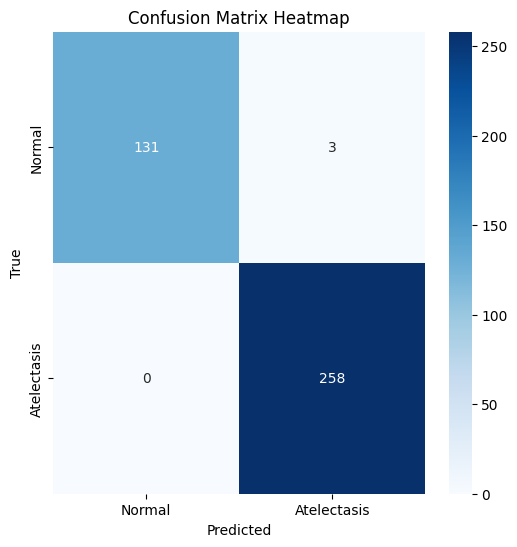

In [10]:

# predictions
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Atelectasis'], yticklabels=['Normal', 'Atelectasis'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


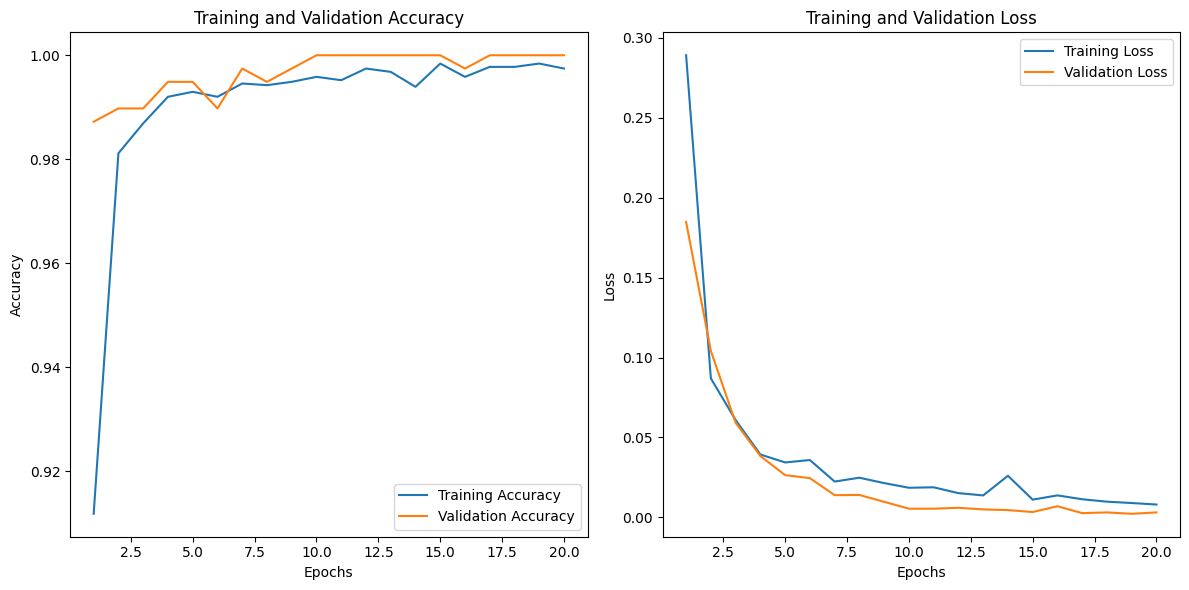

In [11]:
# training and validation metrics
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['loss'], label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


In [12]:
model.save("final_model.keras")